# Tiga Cara Menyimpan dan Mengakses Banyak Gambar dengan Python
**Nama : Rafi Fadhlillah** <br>
**NIM : 121450143** <br>
**Kelas : TBD RC**

In [1]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("C:/Users/rafif/Downloads/cifar-10-python/cifar-10-batches-py")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


In [2]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\rafif\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
pip install lmdb

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\rafif\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


## Memulai dengan HDF5

In [4]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\rafif\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Menyimpan Satu Gambar

In [5]:
from pathlib import Path

disk_dir = Path("C:/Users/rafif/Downloads/cifar-10-python/disk")
lmdb_dir = Path("C:/Users/rafif/Downloads/cifar-10-python/lmdb")
hdf5_dir = Path("C:/Users/rafif/Downloads/cifar-10-python/hdf5")

In [6]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

### Menyimpan ke Disk

In [7]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

### Menyimpan ke LMDB

In [8]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary 
        # for this dataset, but some datasets may include images of 
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

In [9]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

### Menyimpan dengan HDF5

In [10]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

## Eksperimen untuk menyimpan satu gambar

In [11]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

In [12]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.0257011000003331
Method: lmdb, Time usage: 0.0027094999995824764
Method: hdf5, Time usage: 0.008783500000390632


## Menyimpan Banyak Gambar

In [13]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

### Mempersiapkan Himpunan Data

In [14]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


In [15]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.010193800000706688
Method: lmdb, Time usage: 0.003033299999515293
Method: hdf5, Time usage: 0.001932699999997567
Method: disk, Time usage: 0.0794700999995257
Method: lmdb, Time usage: 0.0044664999995802646
Method: hdf5, Time usage: 0.0017071000002033543
Method: disk, Time usage: 0.8345959999996921
Method: lmdb, Time usage: 0.021820399999342044
Method: hdf5, Time usage: 0.0029260000001158915
Method: disk, Time usage: 8.097109600000294
Method: lmdb, Time usage: 0.2210958000005121
Method: hdf5, Time usage: 0.01689059999989695
Method: disk, Time usage: 80.82425559999956
Method: lmdb, Time usage: 2.4537064000005557
Method: hdf5, Time usage: 0.24317579999933514


C:\Users\rafif\AppData\Local\Temp\ipykernel_12828\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


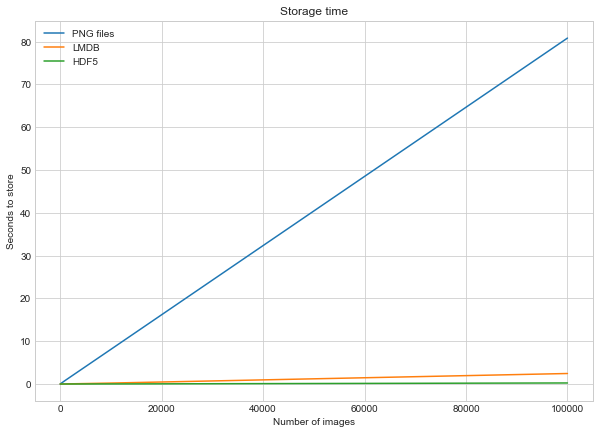

C:\Users\rafif\AppData\Local\Temp\ipykernel_12828\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


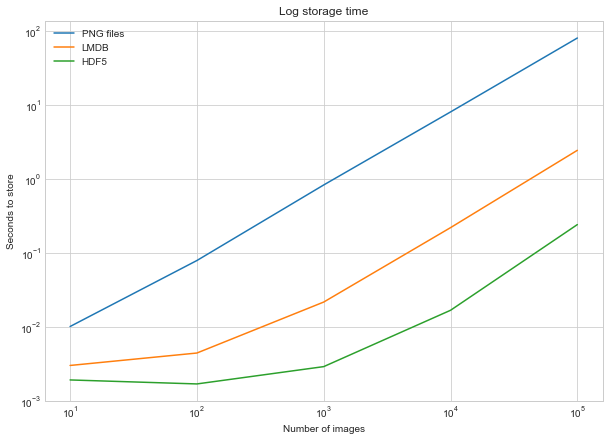

In [16]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

## Membaca Satu Gambar

### Membaca Dari Disk

In [17]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

### Membaca dari LMDB

In [18]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

### Membaca dari HDF5

In [19]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

In [20]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

## Eksperimen untuk Membaca Satu Gambar

In [21]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.002354100000047765
Method: lmdb, Time usage: 0.011813299999630544
Method: hdf5, Time usage: 0.00641170000017155


## Membaca Banyak Gambar

In [22]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object 
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

## Eksperimen untuk Membaca Banyak Gambar

In [23]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=0,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")

Method: disk, No. images: 10, Time usage: 2.999995558639057e-07
Method: lmdb, No. images: 10, Time usage: 2.999995558639057e-07
Method: hdf5, No. images: 10, Time usage: 2.999995558639057e-07
Method: disk, No. images: 100, Time usage: 3.0000046535860747e-07
Method: lmdb, No. images: 100, Time usage: 2.999995558639057e-07
Method: hdf5, No. images: 100, Time usage: 2.0000061340397224e-07
Method: disk, No. images: 1000, Time usage: 1.9999970390927047e-07
Method: lmdb, No. images: 1000, Time usage: 4.000003173132427e-07
Method: hdf5, No. images: 1000, Time usage: 2.0000061340397224e-07
Method: disk, No. images: 10000, Time usage: 1.9999970390927047e-07
Method: lmdb, No. images: 10000, Time usage: 1.9999970390927047e-07
Method: hdf5, No. images: 10000, Time usage: 1.9999970390927047e-07
Method: disk, No. images: 100000, Time usage: 2.0000061340397224e-07
Method: lmdb, No. images: 100000, Time usage: 1.9999970390927047e-07
Method: hdf5, No. images: 100000, Time usage: 1.9999970390927047e-07


C:\Users\rafif\AppData\Local\Temp\ipykernel_12828\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


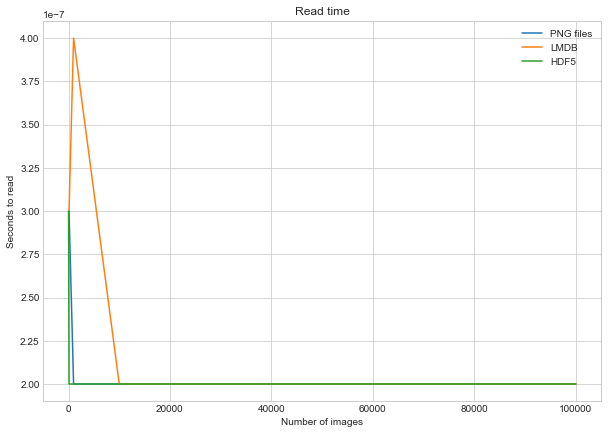

C:\Users\rafif\AppData\Local\Temp\ipykernel_12828\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


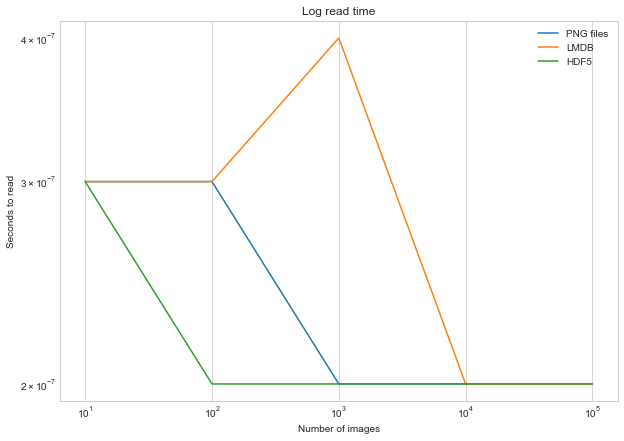

In [24]:
disk_x_r = read_many_timings["disk"]
lmdb_x_r = read_many_timings["lmdb"]
hdf5_x_r = read_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Read time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Log read time",
    log=True,
)

C:\Users\rafif\AppData\Local\Temp\ipykernel_12828\2568719458.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


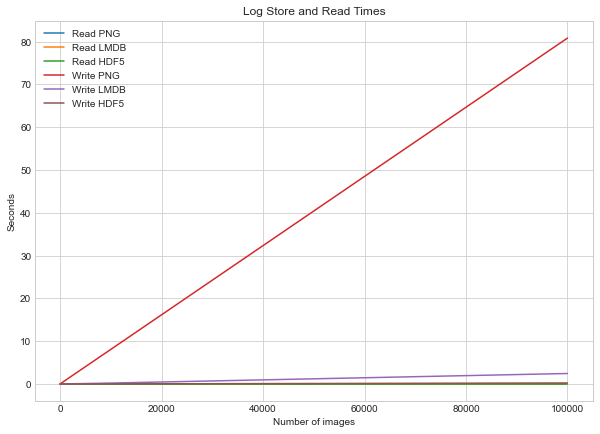

In [25]:
plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r, disk_x, lmdb_x, hdf5_x],
    [
        "Read PNG",
        "Read LMDB",
        "Read HDF5",
        "Write PNG",
        "Write LMDB",
        "Write HDF5",
    ],
    "Number of images",
    "Seconds",
    "Log Store and Read Times",
    log=False,
)

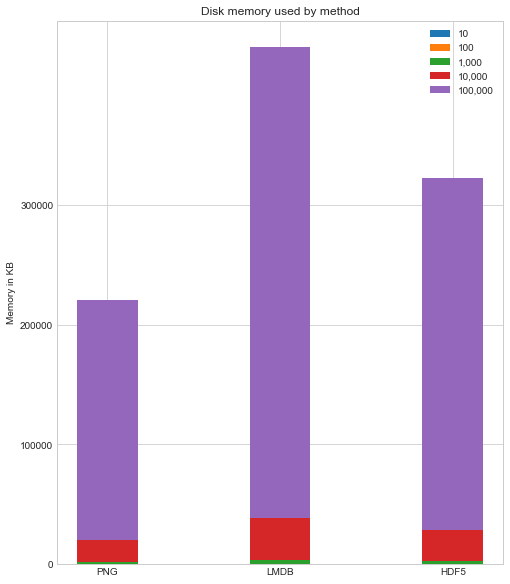

In [26]:
# Memory used in KB
disk_mem = [24, 204, 2004, 20032, 200296]
lmdb_mem = [60, 420, 4000, 39000, 393000]
hdf5_mem = [36, 304, 2900, 29000, 293000]

X = [disk_mem, lmdb_mem, hdf5_mem]

ind = np.arange(3)
width = 0.35

plt.subplots(figsize=(8, 10))
plots = [plt.bar(ind, [row[0] for row in X], width)]
for i in range(1, len(cutoffs)):
    plots.append(
        plt.bar(
            ind, [row[i] for row in X], width, bottom=[row[i - 1] for row in X]
        )
    )

plt.ylabel("Memory in KB")
plt.title("Disk memory used by method")
plt.xticks(ind, ("PNG", "LMDB", "HDF5"))
plt.yticks(np.arange(0, 400000, 100000))

plt.legend(
    [plot[0] for plot in plots], ("10", "100", "1,000", "10,000", "100,000")
)
plt.show()